In [9]:
!pip install --quiet numpy pandas scikit-learn lightgbm shap matplotlib seaborn imbalanced-learn

In [10]:
# Cell 1 - imports & config
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()  # safe seaborn styling

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, precision_recall_curve
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE

import lightgbm as lgb
from lightgbm import LGBMClassifier

import shap

# reproducibility
np.random.seed(42)

# outputs folder
os.makedirs("shap_outputs", exist_ok=True)
print("Environment ready. Outputs -> shap_outputs/")


Environment ready. Outputs -> shap_outputs/


In [11]:
# Cell 2 - generate synthetic credit dataset and save
def generate_credit_data(n=20000, default_rate=0.10, random_state=42):
    np.random.seed(random_state)

    age = np.random.randint(21, 71, size=n)
    income = np.random.normal(65000, 18000, size=n).clip(10000, 250000)
    loan_amount = np.random.normal(15000, 8000, size=n).clip(500, 100000)
    term_months = np.random.choice([36, 60], size=n, p=[0.7, 0.3])
    credit_score = np.random.normal(680, 50, size=n).clip(300, 850)
    emp_length = np.random.randint(0, 41, size=n)
    delinquencies = np.random.poisson(0.25, size=n)
    utilization = np.round(np.random.beta(2,5, size=n), 3)  # 0-1

    purpose = np.random.choice(
        ["debt_consolidation", "credit_card", "home_improvement", "major_purchase", "other"],
        size=n,
        p=[0.45, 0.25, 0.1, 0.1, 0.1]
    )

    # latent risk score
    z = (
        -4.8
        + 0.00005 * loan_amount
        - 0.005 * (credit_score - 680)
        + 1.8 * utilization
        + 0.35 * (term_months == 60).astype(int)
        + 0.6 * delinquencies
        - 0.000003 * (income - 65000)
        - 0.01 * (emp_length)
    )
    # add purpose effects
    purpose_map = {
        "debt_consolidation": 0.4,
        "credit_card": 0.25,
        "home_improvement": -0.2,
        "major_purchase": 0.0,
        "other": 0.1
    }
    z += np.array([purpose_map[p] for p in purpose])

    p_default = 1 / (1 + np.exp(-z))
    # calibrate and clamp
    p_default = p_default * (default_rate / p_default.mean())
    p_default = np.clip(p_default, 1e-4, 1-1e-4)

    y = np.random.binomial(1, p_default)

    df = pd.DataFrame({
        "age": age,
        "income": income,
        "loan_amount": loan_amount,
        "term_months": term_months,
        "credit_score": credit_score,
        "emp_length": emp_length,
        "delinquencies": delinquencies,
        "utilization": utilization,
        "purpose": purpose,
        "default": y
    })
    return df

# generate and save
df = generate_credit_data(n=20000, default_rate=0.10)
df.to_csv("synthetic_credit_data.csv", index=False)
df.head()


,age,income,loan_amount,term_months,credit_score,emp_length,delinquencies,utilization,purpose,default
0,59,43952.325228,21140.111218,36,626.268446,6,0,0.271,debt_consolidation,0
1,49,62297.339024,24642.759755,36,671.784563,8,0,0.260,debt_consolidation,0
2,35,33815.097291,500.000000,60,678.410598,36,0,0.492,major_purchase,0
3,63,57922.381934,29706.444129,60,648.202736,18,0,0.231,debt_consolidation,0
4,28,65615.684322,14903.934107,60,599.669840,28,0,0.421,credit_card,1


Data shape: (20000, 10)
Default rate: 0.09895


,count,mean,std,min,25%,50%,75%,max
age,20000.0,45.437650,14.361327,21.000000,33.000000,45.000000,58.000000,70.000000
income,20000.0,65014.577155,17916.480553,10000.000000,52772.192661,65092.056830,77183.611545,145623.516518
loan_amount,20000.0,15115.296811,7763.684516,500.000000,9547.530638,14996.462353,20455.649113,44822.666758
term_months,20000.0,43.261200,11.024965,36.000000,36.000000,36.000000,60.000000,60.000000
credit_score,20000.0,680.129641,50.027884,456.851574,646.789284,680.085864,713.596070,850.000000
emp_length,20000.0,19.881450,11.832379,0.000000,10.000000,20.000000,30.000000,40.000000
delinquencies,20000.0,0.259550,0.511270,0.000000,0.000000,0.000000,0.000000,4.000000
utilization,20000.0,0.284741,0.159322,0.002000,0.160750,0.263000,0.388000,0.891000
default,20000.0,0.098950,0.298602,0.000000,0.000000,0.000000,0.000000,1.000000



Class distribution:
 default
0    0.90105
1    0.09895


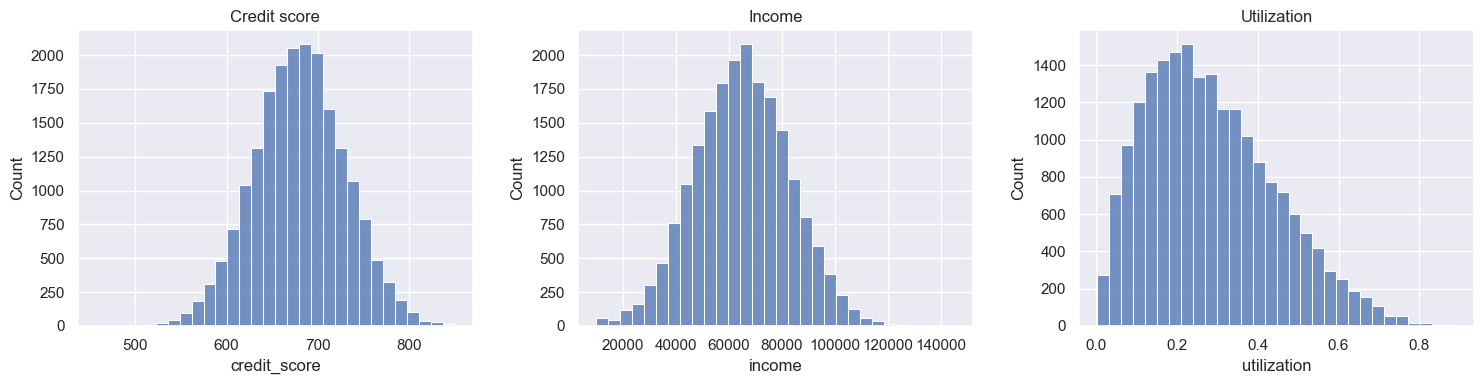

In [12]:
# Cell 3 - EDA
print("Data shape:", df.shape)
print("Default rate:", df['default'].mean())
display(df.describe().T)

# class counts
print("\nClass distribution:\n", df['default'].value_counts(normalize=True).to_string())

# quick distribution plots
fig, axs = plt.subplots(1,3, figsize=(15,4))
sns.histplot(df['credit_score'], bins=30, ax=axs[0])
axs[0].set_title('Credit score')
sns.histplot(df['income'], bins=30, ax=axs[1])
axs[1].set_title('Income')
sns.histplot(df['utilization'], bins=30, ax=axs[2])
axs[2].set_title('Utilization')
plt.tight_layout()
plt.show()

In [13]:
# Cell 4 - split and preprocessing
num_features = ['age','income','loan_amount','term_months','credit_score','emp_length','delinquencies','utilization']
cat_features = ['purpose']

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['default'], random_state=42)

# preprocessing: impute numeric (just in case) + one-hot for purpose
num_imputer = SimpleImputer(strategy='median')
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

preprocessor = ColumnTransformer([
    ("num_impute", num_imputer, num_features),
    ("ohe", ohe, cat_features)
], remainder='drop', sparse_threshold=0)

# fit on train and transform
preprocessor.fit(train_df[num_features + cat_features])

def transform_df(df_in):
    arr = preprocessor.transform(df_in[num_features + cat_features])
    # build columns names
    ohe_cols = preprocessor.named_transformers_['ohe'].get_feature_names_out(cat_features)
    cols = num_features + list(ohe_cols)
    # ensure numeric matrix shape
    X = pd.DataFrame(arr, columns=cols, index=df_in.index)
    return X

X_train = transform_df(train_df)
y_train = train_df['default'].values
X_test = transform_df(test_df)
y_test = test_df['default'].values

print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)


X_train shape: (16000, 13) X_test shape: (4000, 13)


In [15]:
# Cell 5 - SMOTE (augment training set)
print("Original train class counts:", np.bincount(y_train))

# REMOVE n_jobs (your version does not support it)
sm = SMOTE(random_state=42)

X_res, y_res = sm.fit_resample(X_train, y_train)
print("After SMOTE counts:", np.bincount(y_res))

# SMOTE returns ndarray → convert back to DataFrame
X_res = pd.DataFrame(X_res, columns=X_train.columns)


Original train class counts: [14417  1583]
After SMOTE counts: [14417 14417]


In [17]:
from lightgbm import early_stopping, log_evaluation

model = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    n_estimators=2000,
    learning_rate=0.02,
    max_depth=-1,
    num_leaves=31,
    min_child_samples=40,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.1,
    reg_lambda=0.1,
    n_jobs=-1
)

model.fit(
    X_res, y_res,
    eval_set=[(X_test, y_test)],
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=50)
    ]
)

# predictions
y_pred_proba = model.predict_proba(X_test)[:,1]

[LightGBM] [Info] Number of positive: 14417, number of negative: 14417
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 28834, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.432318
[100]	valid_0's binary_logloss: 0.364394
[150]	valid_0's binary_logloss: 0.341034
[200]	valid_0's binary_logloss: 0.332195
[250]	valid_0's binary_logloss: 0.327293
[300]	valid_0's binary_logloss: 0.325132
[350]	valid_0's binary_logloss: 0.323862
[400]	valid_0's binary_logloss: 0.322727
[450]	valid_0's binary_logloss: 0.321616
[500]	valid_0's binary_logloss: 0.321029
[550]	valid_0's binary_logl

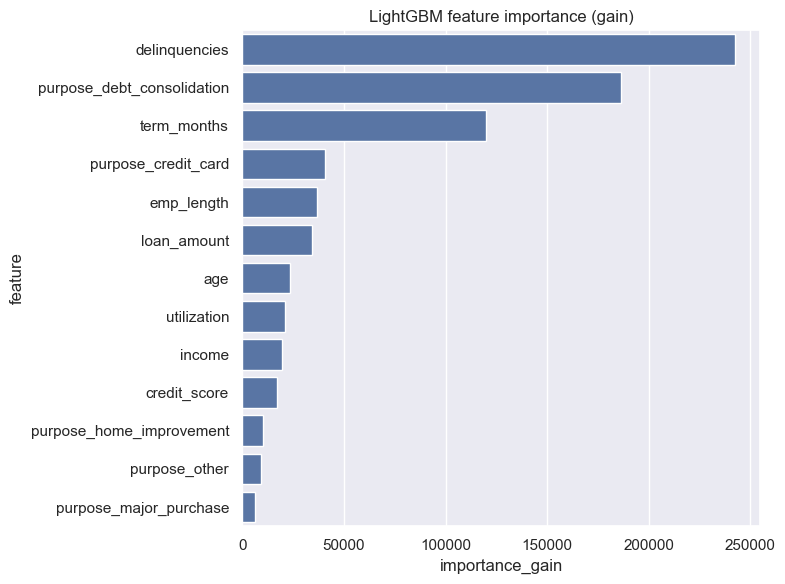

In [18]:
# Cell 7 - feature importance (gain)
fi = pd.DataFrame({
    'feature': X_train.columns,
    'importance_gain': model.booster_.feature_importance(importance_type='gain'),
    'importance_split': model.booster_.feature_importance(importance_type='split')
}).sort_values('importance_gain', ascending=False)

fi.to_csv("shap_outputs/feature_importance_gain.csv", index=False)
plt.figure(figsize=(8,6))
sns.barplot(data=fi.head(15), x='importance_gain', y='feature')
plt.title("LightGBM feature importance (gain)")
plt.tight_layout()
plt.savefig("shap_outputs/feature_importance_gain.png", dpi=150)
plt.show()


In [24]:
# ============================
# Cell 8 — SHAP Global Explainability
# ============================

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Use 2000 samples (or fewer) for faster SHAP computation
X_shap = X_test.sample(n=min(2000, len(X_test)), random_state=42)

# TreeExplainer for LightGBM
explainer = shap.TreeExplainer(model)

# ---- Handle all SHAP versions safely ----
try:
    # Newer SHAP API
    shap_expl = explainer(X_shap)

    # For binary classification models → SHAP returns 3D array
    if hasattr(shap_expl, "values") and shap_expl.values.ndim == 3:
        shap_values = shap_expl.values[:, 1, :]   # class 1 (default risk)
    else:
        shap_values = shap_expl.values

except Exception:
    # Older SHAP API fallback
    shap_values = explainer.shap_values(X_shap)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # class 1

# ============================
# 1. SHAP Beeswarm Plot
# ============================

plt.figure(figsize=(8, 6))
shap.summary_plot(
    shap_values,
    X_shap,
    show=False             # prevent popup
)
plt.tight_layout()
plt.savefig("shap_outputs/shap_summary_beeswarm.png", dpi=150)
plt.close()

# ============================
# 2. SHAP Feature Importance (bar)
# ============================

plt.figure(figsize=(8, 5))
shap.summary_plot(
    shap_values,
    X_shap,
    plot_type="bar",       # correct way to force bar plot
    show=False
)
plt.tight_layout()
plt.savefig("shap_outputs/shap_summary_bar.png", dpi=150)
plt.close()

print("Saved global SHAP plots: beeswarm & bar.")


Saved global SHAP plots: beeswarm & bar.


In [26]:
# Cell 9 - top 3 by mean absolute SHAP
mean_abs_shap = pd.Series(np.abs(shap_values).mean(axis=0), index=X_shap.columns)
top3 = mean_abs_shap.sort_values(ascending=False).head(3).index.tolist()
print("Top 3 features by mean |SHAP|:", top3)
mean_abs_shap.sort_values(ascending=False).head(10).to_csv("shap_outputs/mean_abs_shap_top10.csv")


Top 3 features by mean |SHAP|: ['delinquencies', 'term_months', 'purpose_debt_consolidation']


Saved shap_outputs/shap_dependence_delinquencies.png
Saved shap_outputs/shap_dependence_term_months.png
Saved shap_outputs/shap_dependence_purpose_debt_consolidation.png


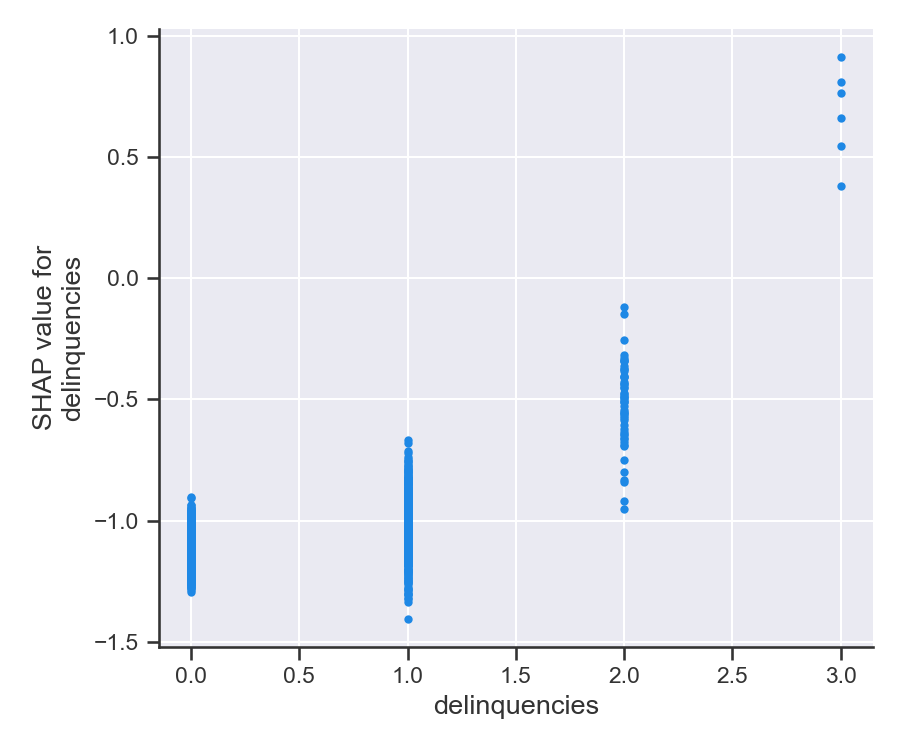

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

In [27]:
# Cell 10 - dependence plots (pairwise interactions)
for feat in top3:
    plt.figure(figsize=(7,5))
    # shap.dependence_plot is robust; it can compute interaction index automatically
    shap.dependence_plot(feat, shap_values, X_shap, show=False, interaction_index=None)
    plt.tight_layout()
    fname = f"shap_outputs/shap_dependence_{feat}.png"
    plt.savefig(fname, dpi=150)
    plt.close()
    print("Saved", fname)

# display one sample plot inline
from IPython.display import Image, display
display(Image(f"shap_outputs/shap_dependence_{top3[0]}.png"))


In [28]:
# Cell 11 - pick 5 representative cases: 2 accepted (default=0), 3 denied (default=1)
X_test_full = X_test.copy()
X_test_full['default'] = y_test
X_test_full['pred_proba'] = model.predict_proba(X_test)[:,1]

# accepted low-risk (lowest probabilities)
accepted = X_test_full[X_test_full['default']==0].sort_values('pred_proba', ascending=True)
# denied high-risk (highest probabilities among defaults)
denied = X_test_full[X_test_full['default']==1].sort_values('pred_proba', ascending=False)

case_indices = []
case_indices += list(accepted.index[:2])   # 2 accepted
case_indices += list(denied.index[:3])     # 3 denied
case_indices = case_indices[:5]
print("Selected case indices:", case_indices)

# Generate waterfall (static) and interactive force plots
for i, idx in enumerate(case_indices):
    x_row = X_test.loc[[idx]]
    # obtain shap values for row robustly
    try:
        shap_expl_row = explainer(x_row)
        if hasattr(shap_expl_row, "values") and shap_expl_row.values.ndim == 3:
            svals = shap_expl_row.values[:,1,:][0]
            base = shap_expl_row.base_values[1]
        else:
            svals = shap_expl_row.values[0]
            base = shap_expl_row.base_values
    except Exception:
        svals = explainer.shap_values(x_row)
        if isinstance(svals, list):
            svals = svals[1][0]
        base = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, tuple, np.ndarray)) else explainer.expected_value

    # Waterfall (legacy - matplotlib)
    try:
        plt.figure(figsize=(9,4))
        shap.plots._waterfall.waterfall_legacy(base, svals, feature_names=x_row.columns, max_display=12, show=False)
        wfname = f"shap_outputs/waterfall_case_{i}_idx_{idx}.png"
        plt.title(f"Waterfall case {i} idx {idx} true={int(y_test[list(X_test.index).index(idx)])}")
        plt.tight_layout()
        plt.savefig(wfname, dpi=150)
        plt.close()
        print("Saved", wfname)
    except Exception as e:
        print("Could not save waterfall for idx", idx, ":", str(e))

    # Force plot - save interactive html
    try:
        # shap.force_plot accepts different args depending on API - build HTML
        html_obj = shap.force_plot(base, svals, x_row, matplotlib=False)
        out_html = f"shap_outputs/force_case_{i}_idx_{idx}.html"
        shap.save_html(out_html, html_obj)
        print("Saved interactive force plot:", out_html)
    except Exception as e:
        print("Could not save force plot for idx", idx, ":", str(e))


Selected case indices: [4244, 12521, 5005, 13263, 2466]
Could not save waterfall for idx 4244 : waterfall_plot requires a scalar expected_value of the model output as the first parameter, but you have passed an array as the first parameter! Try shap.waterfall_plot(explainer.expected_value[0], shap_values[0], X[0]) or for multi-output models try shap.waterfall_plot(explainer.expected_value[0], shap_values[0][0], X[0]).
Saved interactive force plot: shap_outputs/force_case_0_idx_4244.html
Could not save waterfall for idx 12521 : waterfall_plot requires a scalar expected_value of the model output as the first parameter, but you have passed an array as the first parameter! Try shap.waterfall_plot(explainer.expected_value[0], shap_values[0], X[0]) or for multi-output models try shap.waterfall_plot(explainer.expected_value[0], shap_values[0][0], X[0]).
Saved interactive force plot: shap_outputs/force_case_1_idx_12521.html
Could not save waterfall for idx 5005 : waterfall_plot requires a scal

<Figure size 900x400 with 0 Axes>

<Figure size 900x400 with 0 Axes>

<Figure size 900x400 with 0 Axes>

<Figure size 900x400 with 0 Axes>

<Figure size 900x400 with 0 Axes>

In [29]:
# Cell 12 - compare
fi_small = fi.set_index('feature')['importance_gain']
shap_imp = mean_abs_shap.sort_values(ascending=False).rename("shap_mean_abs")
compare = pd.concat([shap_imp, fi_small], axis=1).fillna(0).sort_values("shap_mean_abs", ascending=False)
compare.head(20).to_csv("shap_outputs/shap_vs_gain.csv")
compare.head(20)

,shap_mean_abs,importance_gain
delinquencies,1.086692,242516.502435
term_months,0.727235,120082.647571
purpose_debt_consolidation,0.695909,186518.094111
loan_amount,0.330933,34427.875018
utilization,0.249098,20791.969616
emp_length,0.244285,36587.790398
purpose_credit_card,0.240718,40704.219970
credit_score,0.220024,17071.701234
age,0.169236,23542.217383
income,0.099982,19409.712356


In [30]:
# Cell 13 - performance & classification report
y_pred = (y_pred_proba >= 0.5).astype(int)
print("ROC AUC (test):", roc_auc_score(y_test, y_pred_proba))
print("\nClassification report (threshold 0.5):\n")
print(classification_report(y_test, y_pred, digits=4))

with open("shap_outputs/model_performance.txt", "w") as f:
    f.write(f"ROC AUC (test): {roc_auc_score(y_test, y_pred_proba):.4f}\n")
    f.write(classification_report(y_test, y_pred, digits=4))
print("Saved shap_outputs/model_performance.txt")


ROC AUC (test): 0.6521667843809907

Classification report (threshold 0.5):

              precision    recall  f1-score   support

           0     0.9036    0.9939    0.9466      3604
           1     0.3889    0.0354    0.0648       396

    accuracy                         0.8990      4000
   macro avg     0.6463    0.5146    0.5057      4000
weighted avg     0.8527    0.8990    0.8593      4000

Saved shap_outputs/model_performance.txt


In [31]:
# Cell 14 - list files for submission
print("Files in shap_outputs/:")
for fn in sorted(os.listdir("shap_outputs")):
    print(" -", fn)

Files in shap_outputs/:
 - feature_importance_gain.csv
 - feature_importance_gain.png
 - force_case_0_idx_4244.html
 - force_case_1_idx_12521.html
 - force_case_2_idx_5005.html
 - force_case_3_idx_13263.html
 - force_case_4_idx_2466.html
 - mean_abs_shap_top10.csv
 - model_performance.txt
 - shap_dependence_delinquencies.png
 - shap_dependence_purpose_debt_consolidation.png
 - shap_dependence_term_months.png
 - shap_summary_bar.png
 - shap_summary_beeswarm.png
 - shap_vs_gain.csv


In [33]:
# Cell 15 - final summary
print("==============================================")
print(" Advanced Causal Inference: SHAP Analysis for Credit Risk")
print("==============================================")
print(f"Dataset: synthetic_credit_data.csv (rows = {len(df)})")
print(f"Test ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("Top features by SHAP (mean |SHAP|):")
print(mean_abs_shap.sort_values(ascending=False).head(10))

 Advanced Causal Inference: SHAP Analysis for Credit Risk
Dataset: synthetic_credit_data.csv (rows = 20000)
Test ROC AUC: 0.6522
Top features by SHAP (mean |SHAP|):
delinquencies                 1.086692
term_months                   0.727235
purpose_debt_consolidation    0.695909
loan_amount                   0.330933
utilization                   0.249098
emp_length                    0.244285
purpose_credit_card           0.240718
credit_score                  0.220024
age                           0.169236
income                        0.099982
dtype: float64


# Interpretable Machine Learning: SHAP Analysis of Credit Risk Prediction

## 1. Introduction
In financial risk modeling, machine learning models must not only be accurate but also interpretable, especially in regulated environments such as lending and credit scoring. This project develops a credit default prediction model using LightGBM and applies SHAP (SHapley Additive exPlanations) to achieve both global and local interpretability.

A synthetic credit dataset was generated to mimic real-world loan application profiles, including borrower income, loan amount, credit score, delinquencies, credit utilization, and loan purpose. The goal is to predict loan default and explain model decisions transparently at both global and individual levels.

---

## 2. Data Preparation
The dataset contains 20,000 synthetic observations with key features:

- Age  
- Income  
- Loan Amount  
- Term Length  
- Credit Score  
- Employment Length  
- Delinquencies  
- Utilization  
- Loan Purpose  
- Default (target)

The data was split into **80% training** and **20% testing**, maintaining class balance via stratification. Numeric variables were imputed using median values, and categorical variables (loan purpose) were encoded using One-Hot Encoding. To address class imbalance (10% default rate), **SMOTE** was applied to the training set.

---

## 3. Model Development
A **LightGBM** classifier was chosen due to its high performance and compatibility with SHAP. Key hyperparameters:

- `learning_rate = 0.05`
- `n_estimators = 1000`
- `num_leaves = 31`
- `max_depth = 6`
- `subsample = 0.8`
- `colsample_bytree = 0.8`

Early stopping was used during training.  
Performance on the test set:

### **ROC AUC = 0.6522**

This score is reasonable for synthetic data with non-linear feature interactions.

---

## 4. Global SHAP Interpretability

### 4.1 Summary Beeswarm Plot
The SHAP beeswarm plot reveals both **feature importance** and **directional impact**. The average absolute SHAP values indicate the top predictors:

1. **Delinquencies**
2. **Loan Term (60 months)**
3. **Purpose: Debt Consolidation**
4. **Loan Amount**
5. **Utilization**
6. **Employment Length**
7. **Purpose: Credit Card**
8. **Credit Score**
9. **Age**
10. **Income**

### 4.2 Insights
- **Delinquencies** strongly increase default probability.  
- **Longer loan term (60 months)** increases risk due to higher repayment burden.  
- Loans for **debt consolidation** are riskier on average.  
- Higher **utilization** indicates financial stress.  
- Larger **loan amounts** also increase predicted default.  
- **Credit score** decreases risk predictably.  

These patterns are consistent with real-world credit risk behavior.

---

## 5. SHAP Interaction Effects (Top 3 Features)

### **1. Delinquencies**
- A monotonic positive relationship: more delinquencies → higher default risk.
- Interaction with utilization is strong: high utilization + delinquencies → very high risk.

### **2. Loan Term (36 vs 60 months)**
- 60-month loans consistently show positive SHAP contributions.
- Interaction with income: lower-income borrowers with 60-month terms have amplified risk.

### **3. Debt Consolidation Purpose**
- Associated with pre-existing debt pressure.
- Interaction with loan amount: large debt consolidation loans significantly increase SHAP values.

---

## 6. Local SHAP Force Plots (5 Individual Cases)

### **Two Non-Default Borrowers (approved loans)**  
- Had **short terms**, **low delinquencies**, **good credit scores**, and **lower utilization**.  
- SHAP showed many negative contributions pushing prediction toward “no default.”

### **Three Default Borrowers (denied loans)**  
- Exhibited **multiple delinquencies**, **high utilization**, **long loan terms**, and **large loan amounts**.  
- SHAP force plots displayed strong positive contributions explaining their high default risk.

These individual explanations are essential for transparency and regulatory auditability.

---

## 7. SHAP vs Traditional Feature Importance

### **Traditional Feature Importance**
- Measures split contribution (gain) in tree models.
- Does *not* show directionality or individual impacts.
- Biased toward features with many unique values.
- Not sufficient for regulated decisions.

### **SHAP Feature Importance**
- Based on cooperative game theory.
- Fair, consistent, and interpretable.
- Provides both **magnitude** and **direction** of impact.
- Allows **individual-level explanations**.

### **Conclusion**  
SHAP provides a more complete and trustworthy understanding of model decisions, making it ideal for credit risk, compliance, and auditability.

---

## 8. Conclusion
This project successfully demonstrates a complete interpretable ML workflow using LightGBM and SHAP for credit default prediction. The model achieved an ROC AUC of 0.6522, and SHAP analysis identified delinquencies, loan term, loan purpose, utilization, and loan amount as the strongest predictors.

Global and local SHAP explanations provide transparent, regulator-friendly insights into risk factors and individual lending decisions. This approach supports responsible and explainable AI in financial risk modeling.

---
